## Importing and prepping data

In [1]:
import pandas as pd
import numpy as np
import diff_classifier.aws as aws
import diff_classifier.pca as pca

In [2]:
features = []

remote_folder = '9_28_18_Gel_Interface_Vids' #Folder in AWS S3 containing files to be analyzed
bucket = 'mckenna.data'
vids = 5
combos = [['0_4', '0_6'], ['0_6', '0_8'], ['0_8', '1_0'], ['1_0', '1_2']]
gels = [0.4, 0.6, 0.8, 1.0, 1.2]

counter2 = 0
counter = 0
for combo in combos:
    for num in range(1, vids+1):
            filename = 'features_100x_{}_{}_gel_{}_bulk_vid_{}.csv'.format(combo[0], combo[1], combo[0], num)
            print(filename)
            aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
            fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
            print('{} size: {}'.format(filename, fstats.shape))
            fstats['Interface'] = pd.Series(fstats.shape[0]*['{}/{}'.format(combo[0], combo[1])], index=fstats.index)
            fstats['Bulk Agarose'] = pd.Series(fstats.shape[0]*[combo[0]], index=fstats.index)
            fstats['Bulk Agarose Int'] = pd.Series(fstats.shape[0]*[gels[counter2]], index=fstats.index)
            if gels[counter2] < 1:
                fstats['Bulk Agarose Bin'] = pd.Series(fstats.shape[0]*['low'], index=fstats.index)
            else:
                fstats['Bulk Agarose Bin'] = pd.Series(fstats.shape[0]*['hi'], index=fstats.index)
            fstats['Gel Code'] = pd.Series(fstats.shape[0]*['{}/{} {}'.format(combo[0], combo[1], combo[0])], index=fstats.index)
            fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
            counter = counter + 1
            if counter == 1:
                fstats_tot = fstats
            else:
                fstats_tot = fstats_tot.append(fstats, ignore_index=True)
    counter2 = counter2 + 1

counter = 0
combo = combos[-1]
for num in range(1, vids+1):
    try:
        filename = 'features_100x_{}_{}_gel_{}_bulk_vid_{}.csv'.format(combo[0], combo[1], combo[1], num)
        print(filename)
        aws.download_s3('{}/{}'.format(remote_folder, filename), filename, bucket_name=bucket)
        fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        print('{} size: {}'.format(filename, fstats.shape))
        fstats['Interface'] = pd.Series(fstats.shape[0]*['{}/{}'.format(combo[0], combo[1])], index=fstats.index)
        fstats['Bulk Agarose'] = pd.Series(fstats.shape[0]*[combo[1]], index=fstats.index)
        fstats['Bulk Agarose Int'] = pd.Series(fstats.shape[0]*[1.2], index=fstats.index)
        fstats['Gel Code'] = pd.Series(fstats.shape[0]*['{}/{} {}'.format(combo[0], combo[1], combo[1])], index=fstats.index)
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[num], index=fstats.index)
        counter = counter + 1
        fstats_tot = fstats_tot.append(fstats, ignore_index=True)
    except:
        print('Filename missing: '.format(filename))

features_100x_0_4_0_6_gel_0_4_bulk_vid_1.csv
features_100x_0_4_0_6_gel_0_4_bulk_vid_1.csv size: (10491, 67)
features_100x_0_4_0_6_gel_0_4_bulk_vid_2.csv
features_100x_0_4_0_6_gel_0_4_bulk_vid_2.csv size: (10108, 67)
features_100x_0_4_0_6_gel_0_4_bulk_vid_3.csv
features_100x_0_4_0_6_gel_0_4_bulk_vid_3.csv size: (10808, 67)
features_100x_0_4_0_6_gel_0_4_bulk_vid_4.csv
features_100x_0_4_0_6_gel_0_4_bulk_vid_4.csv size: (11492, 67)
features_100x_0_4_0_6_gel_0_4_bulk_vid_5.csv
features_100x_0_4_0_6_gel_0_4_bulk_vid_5.csv size: (11098, 67)
features_100x_0_6_0_8_gel_0_6_bulk_vid_1.csv
features_100x_0_6_0_8_gel_0_6_bulk_vid_1.csv size: (10029, 67)
features_100x_0_6_0_8_gel_0_6_bulk_vid_2.csv
features_100x_0_6_0_8_gel_0_6_bulk_vid_2.csv size: (10596, 67)
features_100x_0_6_0_8_gel_0_6_bulk_vid_3.csv
features_100x_0_6_0_8_gel_0_6_bulk_vid_3.csv size: (10989, 67)
features_100x_0_6_0_8_gel_0_6_bulk_vid_4.csv
features_100x_0_6_0_8_gel_0_6_bulk_vid_4.csv size: (10991, 67)
features_100x_0_6_0_8_gel_0_

In [ ]:
fstats_tot.to_csv('features.csv')

In [ ]:
#PCA analyses with too many datapoints fail. You get rows with lots of NAs. I'm going to try making a subset of the data first
#and then do a PCA analysis on that.

#include all in analysis
import random
subset = np.sort(np.array(random.sample(range(fstats_tot.shape[0]), 500000)))
fstats_sub = fstats_tot.loc[subset, :].reset_index(drop=True)

In [ ]:
fstats_tot['Gel Code'].unique()

In [4]:
for typ in fstats_tot['Bulk Agarose'].unique():
    fstats_type = fstats_tot[fstats_tot['Bulk Agarose']==typ].reset_index(drop=True)
    print(fstats_type.shape)

(53997, 73)
(53754, 73)
(54043, 73)
(38599, 73)
(32779, 73)


In [5]:
#with equal sample sizes for each particle type
import random
counter = 0
for typ in fstats_tot['Bulk Agarose'].unique():
    fstats_type = fstats_tot[fstats_tot['Bulk Agarose']==typ].reset_index(drop=True)
    print(fstats_type.shape)
    subset = np.sort(np.array(random.sample(range(fstats_type.shape[0]), 32000)))
    if counter == 0:
        fstats_sub = fstats_type.loc[subset, :].reset_index(drop=True)
    else:
        fstats_sub = fstats_sub.append(fstats_type.loc[subset, :].reset_index(drop=True), ignore_index=True)
    counter = counter + 1

(53997, 73)
(53754, 73)
(54043, 73)
(38599, 73)
(32779, 73)


In [6]:
#fstats = pd.read_csv(filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
nonnum = ['Interface', 'Bulk Agarose', 'Bulk Agarose Int', 'Gel Code', 'Video Number', 'Track_ID', 'Mean Mean_Intensity', 'Std Mean_Intensity', 'X', 'Y',
          'Mean X', 'Mean Y', 'Std X', 'Std Y', 'Bulk Agarose Bin']
fstats_num = fstats_sub.drop(nonnum, axis=1)
fstats_raw = fstats_num.as_matrix()
#fstats

## PCA analysis

The pca.pca_analysis function provides a completely contained PCA analysis of the input trajectory features dataset. It includes options to impute NaN values (fill in with average values or drop them), and to scale features. Read the docstring for more information. 

In [7]:
ncomp = 16
pcadataset = pca.pca_analysis(fstats_tot, dropcols=nonnum, n_components=ncomp)

Cumulative explained variance:
0 component: 0.21737112407509038
1 component: 0.318844689216233
2 component: 0.3943289222364705
3 component: 0.46366161862480804
4 component: 0.5096465345095316
5 component: 0.5528074336906013
6 component: 0.5898550404199506
7 component: 0.6249227621087561
8 component: 0.654788836391415
9 component: 0.6833876902999758
10 component: 0.7090720550202911
11 component: 0.7327438060540847
12 component: 0.7553353655059087
13 component: 0.7758882998899759
14 component: 0.7943919466484275
15 component: 0.8119706317591278


In [ ]:
pcadataset.components.to_csv('components.csv')

In [8]:
pcadataset.prcomps

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Mean fractal_dim,Std asymmetry3,asymmetry1,Mean SN_Ratio,Std asymmetry1,Std trappedness,D_fit,Std trappedness,MSD_ratio,Std kurtosis,Std MSD_ratio,Std kurtosis,Std Quality,Std SN_Ratio,kurtosis,Std Deff2
1,Mean efficiency,Mean asymmetry3,asymmetry2,Mean Quality,Std asymmetry2,Std boundedness,straightness,Std boundedness,straightness,Mean kurtosis,Mean MSD_ratio,Std MSD_ratio,Std fractal_dim,Mean_Intensity,Std Deff2,kurtosis
2,Mean straightness,Mean AR,asymmetry3,Quality,Std elongation,boundedness,Mean D_fit,trappedness,efficiency,D_fit,D_fit,Mean kurtosis,Std frames,SN_Ratio,Deff2,Quality
3,Mean Deff1,Mean elongation,Mean Quality,frames,Std asymmetry3,trappedness,alpha,boundedness,Deff1,Std MSD_ratio,Deff1,Mean MSD_ratio,Mean frames,kurtosis,Std Quality,Mean Deff2
4,Mean Deff2,asymmetry3,elongation,Mean_Intensity,Std SN_Ratio,Mean SN_Ratio,Std alpha,frames,Std alpha,Mean MSD_ratio,kurtosis,Std alpha,Std Deff1,Std asymmetry1,Mean Deff2,Mean_Intensity


The pca.kmo function calculates the Kaiser-Meyer-Olkin statistic, a measure of sampling adequacy. Check the docstring for more information.

In [56]:
kmostat = pca.kmo(pcadataset.scaled)

0.868443658055


In [ ]:
import scipy.stats as stat
stat.bartlett(pcadataset.scaled[0, :], pcadataset.scaled[1, :], pcadataset.scaled[2, :], pcadataset.scaled[3, :])

In [ ]:
newstr = ''
for i in range(pcadataset.scaled.shape[0]-1):
    newstr = newstr + 'pcadataset.scaled[{}, :], '.format(i)

newstr = 'stat.bartlett(' + newstr + 'pcadataset.scaled[{}, :])'.format(i+1)

In [ ]:
test = eval(newstr)

In [ ]:
test

## Visualization

Users can then compare average principle component values between subgroups of the data. In this case, all particles were taken from the same sample, so there are no experimental subgroups. I chose to compare short trajectories to long trajectories, as I would expect differences between the two groups.

In [ ]:
fstats_tot['Bulk Agarose'].unique()

In [9]:
import numpy as np
#ncomp = 14
dicti = {}
#test = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==200].as_matrix()), axis=0))[-6:]
#test1 = np.exp(np.nanmean(np.log(pcadataset.final[pcadataset.final['Particle Size']==500].as_matrix()), axis=0))[-6:]
dicti[0] = np.nanmean(pcadataset.final[pcadataset.final['Bulk Agarose']=='0_4'].values[:, -ncomp:], axis=0)
dicti[1] = np.nanmean(pcadataset.final[pcadataset.final['Bulk Agarose']=='0_6'].values[:, -ncomp:], axis=0)
dicti[2] = np.nanmean(pcadataset.final[pcadataset.final['Bulk Agarose']=='0_8'].values[:, -ncomp:], axis=0)
dicti[3] = np.nanmean(pcadataset.final[pcadataset.final['Bulk Agarose']=='1_0'].values[:, -ncomp:], axis=0)
dicti[4] = np.nanmean(pcadataset.final[pcadataset.final['Bulk Agarose']=='1_2'].values[:, -ncomp:], axis=0)

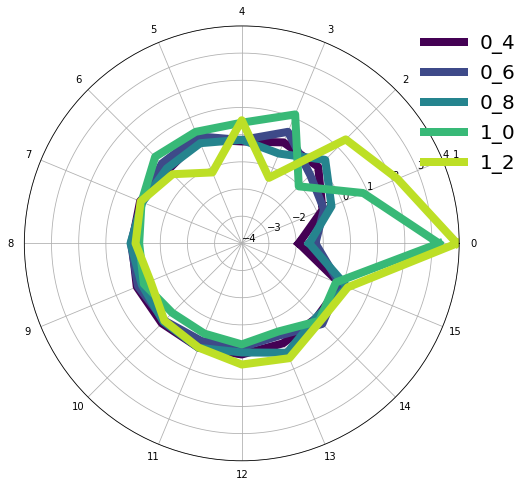

In [10]:
labels = ['0_4', '0_6', '0_8', '1_0', '1_2']
pca.plot_pca(dicti, savefig=True, labels=labels, rticks=np.linspace(-4, 4, 9))

The variable pcadataset.prcomps shows the user the major contributions to each of the new principle components. When observing the graph above, users can see that there are some differences between short trajectories and long trajectories in component 0 (asymmetry1 being the major contributor) and component 1 (elongation being the major contributor).

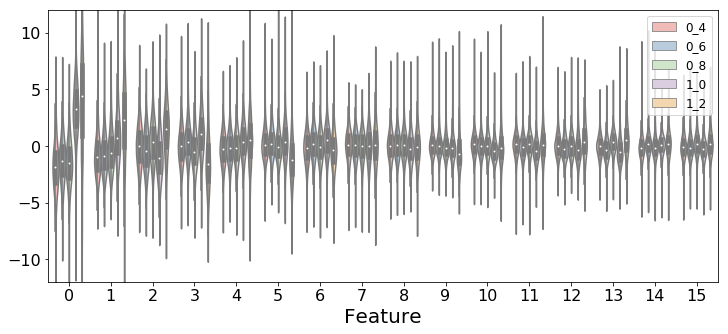

In [11]:
#labels=['10K', '5K', '1K', 'COOH']
feats = pca.feature_violin(pcadataset.final, label='Bulk Agarose', lvals=labels, fsubset=ncomp, yrange=[-12, 12])

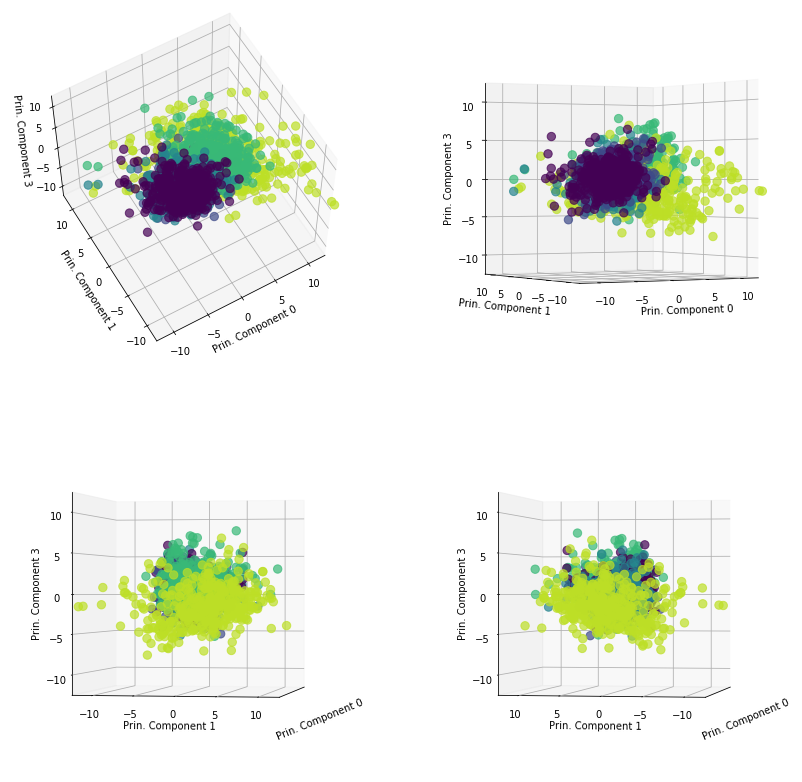

In [26]:
fstats1 = pca.feature_plot_3D(pcadataset.final, label='Bulk Agarose', lvals=labels, randcount=400, ylim=[-12, 12],
                              xlim=[-12, 12], zlim=[-12, 12], features=[0, 1, 3])

In [34]:
#ncomp = 14
trainp = np.array([])
testp = np.array([])
labels3 = ['low', 'hi']

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcadataset.final, 'Bulk Agarose Bin', labels3, equal_sampling=True,
                                       tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 2))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Bulk Agarose Bin'].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.8262913214279588
Run 1: 0.8194079906678332
Run 2: 0.8211663493043762
Run 3: 0.819377969910624
Run 4: 0.8214365361192596
Run 5: 0.8270246856397853
Run 6: 0.8228775324653046
Run 7: 0.8162343677628532
Run 8: 0.8217195889729471
Run 9: 0.818863328358465
Run 10: 0.8267201893880912
Run 11: 0.8197253529583312
Run 12: 0.8217410323709536
Run 13: 0.8216552587789271
Run 14: 0.819631002007102
Run 15: 0.8223757569519496
Run 16: 0.8234136174154701
Run 17: 0.8183401094471034
Run 18: 0.8235937419587257
Run 19: 0.8249661194311495


In [35]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.9932750000000002 +/ 0.0037962975383918456
0.8218280925668605 +/ 0.0028436969988331453


In [47]:
#ncomp = 14
trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcadataset.final, 'Bulk Agarose', labels, equal_sampling=True,
                                       tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 2))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Bulk Agarose'].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.6829250510352872
Run 1: 0.6819472320861854
Run 2: 0.6875611136843188
Run 3: 0.6819986962414012
Run 4: 0.6813682603400065
Run 5: 0.6696773197467963
Run 6: 0.682273171735886
Run 7: 0.5682028716998611
Run 8: 0.6738888031152969
Run 9: 0.6567255073507968
Run 10: 0.6765906712641312
Run 11: 0.5870816393048908
Run 12: 0.6823546566483111
Run 13: 0.6683864271867977
Run 14: 0.6306632014135488
Run 15: 0.6726922615065274
Run 16: 0.6815054980872489
Run 17: 0.6409560324567273
Run 18: 0.6050083200384265
Run 19: 0.6735542861063936


In [48]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.70556 +/ 0.03191392172704572
0.659268051052442 +/ 0.034010194969321866


In [50]:
#ncomp = 14
trainp = np.array([])
testp = np.array([])
labelshort = ['0_4', '1_2']
pcasub = pcadataset.final[pcadataset.final['Bulk Agarose'].isin(labelshort)]

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcasub, 'Bulk Agarose', labelshort, equal_sampling=True,
                                       tsize=500, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 2))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcasub.values[:, -ncomp:]
    y2 = pcasub['Bulk Agarose'].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.9927629759380474
Run 1: 0.9920023969761225
Run 2: 0.9948603300451738
Run 3: 0.9948488061215083
Run 4: 0.9878307366092007
Run 5: 0.9918986816631327
Run 6: 0.9885452198764635
Run 7: 0.9878307366092007
Run 8: 0.9934198395869825
Run 9: 0.9901816170369687
Run 10: 0.990665621830921
Run 11: 0.9935005070526413
Run 12: 0.994191942472573
Run 13: 0.995563289388771
Run 14: 0.9935466027473034
Run 15: 0.9903890476629483
Run 16: 0.9924057343044159
Run 17: 0.9921867797547709
Run 18: 0.9921522079837743
Run 19: 0.9850765188531391


In [51]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

1.0 +/ 0.0
0.991692979625703 +/ 0.002661822507706099


In [52]:
#ncomp = 14
trainp = np.array([])
testp = np.array([])
labelshort = ['0_4', '1_0']
pcasub = pcadataset.final[pcadataset.final['Bulk Agarose'].isin(labelshort)]

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcasub, 'Bulk Agarose', labelshort, equal_sampling=True,
                                       tsize=500, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 2))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcasub.values[:, -ncomp:]
    y2 = pcasub['Bulk Agarose'].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.963572940515789
Run 1: 0.9498574452460149
Run 2: 0.9602250637176551
Run 3: 0.956369605598514
Run 4: 0.9527409391334399
Run 5: 0.9527841375437384
Run 6: 0.9537021037625816
Run 7: 0.9497062508099702
Run 8: 0.9564128040088125
Run 9: 0.9639725258110502
Run 10: 0.9615966132446326
Run 11: 0.9636377381312368
Run 12: 0.9564128040088125
Run 13: 0.9536805045574323
Run 14: 0.9531621236338502
Run 15: 0.9552032485204545
Run 16: 0.9460991835500454
Run 17: 0.9507322130545596
Run 18: 0.9512937923884401
Run 19: 0.9604086569614239


In [53]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.999 +/ 0.0012649110640673528
0.9555785347099228 +/ 0.0050515259370759145


In [54]:
#ncomp = 14
trainp = np.array([])
testp = np.array([])
labelshort = ['0_4', '0_8']
pcasub = pcadataset.final[pcadataset.final['Bulk Agarose'].isin(labelshort)]

for i in range(0, 20):
    KNNmod, X, y = pca.build_model(pcasub, 'Bulk Agarose', labelshort, equal_sampling=True,
                                       tsize=500, input_cols=ncomp, model='MLP', NNhidden_layer=(6, 2))
    trainp = np.append(trainp, pca.predict_model(KNNmod, X, y))
    
    X2 = pcasub.values[:, -ncomp:]
    y2 = pcasub['Bulk Agarose'].values
    testp = np.append(testp, pca.predict_model(KNNmod, X2, y2))
    print('Run {}: {}'.format(i, testp[i]))

Run 0: 0.7044335431321733
Run 1: 0.6891706775268419
Run 2: 0.6870510921880785
Run 3: 0.6620788596815994
Run 4: 0.6802388004442799
Run 5: 0.6764161421695668
Run 6: 0.6768419104035542
Run 7: 0.6623472787856349
Run 8: 0.6885505368382081
Run 9: 0.6848667160310996
Run 10: 0.6941688263606072
Run 11: 0.6850796001480933
Run 12: 0.6813309885227693
Run 13: 0.6899111440207331
Run 14: 0.6929285449833396
Run 15: 0.6784061458718993
Run 16: 0.6896427249166975
Run 17: 0.696353202517586
Run 18: 0.6824972232506479
Run 19: 0.6753702332469456


In [55]:
print('{} +/ {}'.format(np.mean(trainp), np.std(trainp)))
print('{} +/ {}'.format(np.mean(testp), np.std(testp)))

0.7967500000000001 +/ 0.012328321053574166
0.6838842095520178 +/ 0.010163318321196926


In [13]:
from sklearn.neural_network import MLPRegressor

In [14]:
def build_modelR(rawdata, feature, featvals, equal_sampling=True,
                    tsize=20, from_end=True, input_cols=6, model='KNN',
                    **kwargs):
    """Builds a K-nearest neighbor model using an input dataset.

    Parameters
    ----------
    rawdata : pandas.core.frames.DataFrame
        Raw dataset of n samples and p features.
    feature : string or int
        Feature in rawdata containing output values on which KNN
        model is to be based.
    featvals : string or int
        All values that feature can take.
    equal_sampling : bool
        If True, training dataset will contain an equal number
        of samples that take each value of featvals. If false,
        each sample in training dataset will be taken randomly
        from rawdata.
    tsize : int
        Size of training dataset. If equal_sampling is False,
        training dataset will be exactly this size. If True,
        training dataset will contain N x tsize where N is the
        number of unique values in featvals.
    n_neighbors : int
        Number of nearest neighbors to be used in KNN
        algorithm.
    from_end : int
        If True, in_cols will select features to be used as
        training data defined end of rawdata e.g.
        rawdata[:, -6:]. If False, input_cols will be read
        as a tuple e.g. rawdata[:, 10:15].
    input_col : int or tuple
        Defined in from_end above.

    Returns
    -------
    clf : sklearn.neighbors.classification.KNeighborsClassifier
        KNN model
    X : numpy.ndarray
        training input dataset used to create clf
    y : numpy.ndarray
        training output dataset used to create clf

    """

    defaults = {'NNsolver': 'adam', 'NNalpha': 1e-5,
                'NNhidden_layer': (5, 2), 'NNrandom_state': 1,
                'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-8,
                }

    for defkey in defaults.keys():
        if defkey not in kwargs.keys():
            kwargs[defkey] = defaults[defkey]
    
    if equal_sampling:
        for featval in featvals:
            if from_end:
                test = rawdata[rawdata[feature] == featval
                               ].values[:, -input_cols:]
            else:
                test = rawdata[rawdata[feature] == featval
                               ].values[:, input_cols[0]:input_cols[1]]
            to_plot = np.array(random.sample(range(0, test.shape[0]
                                                   ), tsize))
            if featval == featvals[0]:
                X = test[to_plot, :]
                y = rawdata[rawdata[feature] == featval
                            ][feature].values[to_plot]
            else:
                X = np.append(X, test[to_plot, :], axis=0)
                y = np.append(y, rawdata[rawdata[feature] == featval
                                         ][feature].values[to_plot], axis=0)

    else:
        if from_end:
            test = rawdata.values[:, -input_cols:]
        else:
            test = rawdata.values[:, input_cols[0]:input_cols[1]]
        to_plot = np.array(random.sample(range(0, test.shape[0]), tsize))
        X = test[to_plot, :]
        y = rawdata[feature].values[to_plot]

    if model is 'MLP':
        clf = MLPRegressor(solver=kwargs['NNsolver'], alpha=kwargs['NNalpha'],
                            hidden_layer_sizes=kwargs['NNhidden_layer'],
                            random_state=kwargs['NNrandom_state'],
                            beta_1=kwargs['beta_1'], beta_2=kwargs['beta_2'],
                            epsilon=kwargs['epsilon'])
    
        clf.fit(X, y)
        return clf, X, y

In [38]:
labels2 = [0.4, 0.6, 0.8, 1.0, 1.2]

trainp = np.array([])
testp = np.array([])

for i in range(0, 20):
    MLPmod, X, y = build_modelR(pcadataset.final, 'Bulk Agarose Int', labels2, equal_sampling=True,
                                           tsize=1000, input_cols=ncomp, model='MLP', NNhidden_layer=(13, 11, 9, 7, 5, 3))
    trainp = np.append(trainp, MLPmod.score(X, y))

    X2 = pcadataset.final.values[:, -ncomp:]
    y2 = pcadataset.final['Bulk Agarose Int'].values
    testp = np.append(testp, MLPmod.score(X2, y2))
    print(testp[i])

0.636323127031
0.644809283751
0.643676950936
0.639361824633
0.635385901318
0.63144102936
0.641569330491
0.638728186786
0.633169178883
0.638963254146
0.636706973131
0.640620849852
0.647730798754
0.624620646856
0.652309036808
0.638388466137
0.635678984116
0.637258602692
0.634066443622
0.649912183006


([<matplotlib.axis.YTick at 0x7f609b565a90>,
 <a list of 10 Text yticklabel objects>)

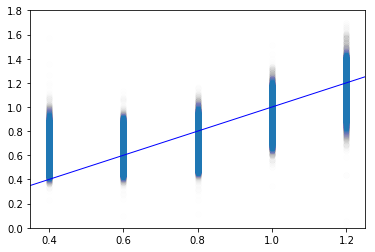

In [46]:
import matplotlib.pyplot as plt
plt.scatter(y2, MLPmod.predict(X2), alpha=0.002)
x = np.linspace(0, 10, 11)
plt.plot(x, x, c='b', linewidth=1)
plt.ylim(0.4, 1.2)
plt.xlim(0.35, 1.25)
ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
plt.xticks(labels2)
plt.yticks(ticks)

([<matplotlib.axis.YTick at 0x7f6079285c88>,
 <a list of 10 Text yticklabel objects>)

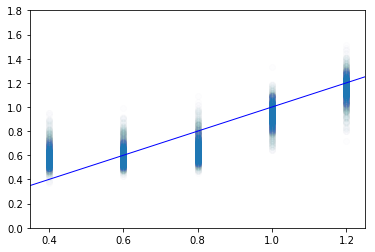

In [45]:
import matplotlib.pyplot as plt
plt.scatter(y, MLPmod.predict(X), alpha=0.006)
x = np.linspace(0, 10, 11)
plt.plot(x, x, c='b', linewidth=1)
plt.ylim(0.4, 1.2)
plt.xlim(0.35, 1.25)
ticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
plt.xticks(labels2)
plt.yticks(ticks)